In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.5 MB/s eta 0:00:00


In [2]:
# Uncomment to install if missing
# !pip install pulp numpy pandas scikit-learn matplotlib

import re
from pathlib import Path
import math, time
import numpy as np
import pandas as pd
import pulp
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,5)


In [22]:
import re

def parse_RC2_instance(path):
    """
    Parse RC2_10_10 Solomon-style instance with header blocks:
    VEHICLE
    NUMBER     CAPACITY
    <count>    <capacity>

    CUSTOMER
    CUST NO.   XCOORD.  YCOORD.  DEMAND  READY TIME  DUE DATE  SERVICE TIME
    """
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    # --- Find vehicle number and capacity ---
    vehicle_count = None
    vehicle_capacity = None
    for i, ln in enumerate(lines):
        if ln.upper().startswith("VEHICLE"):
            # Expect "NUMBER     CAPACITY" in next line, and values in line after that
            if i + 2 < len(lines):
                nums = re.findall(r'\d+', lines[i+2])
                if len(nums) >= 2:
                    vehicle_count = int(nums[0])
                    vehicle_capacity = int(nums[1])
            break

    if vehicle_count is None or vehicle_capacity is None:
        raise ValueError("Could not find vehicle number and capacity in file.")

    # --- Find where customer data starts ---
    cust_start_idx = None
    for i, ln in enumerate(lines):
        if ln.upper().startswith("CUSTOMER"):
            cust_start_idx = i + 2  # Skip header line after "CUSTOMER"
            break
    if cust_start_idx is None:
        raise ValueError("Could not find CUSTOMER section.")

    # --- Parse nodes ---
    nodes = []
    for ln in lines[cust_start_idx:]:
        parts = re.findall(r'-?\d+\.?\d*', ln)
        if len(parts) >= 7:
            cid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            demand = int(parts[3])
            ready = float(parts[4])
            due = float(parts[5])
            service = float(parts[6])
            nodes.append({
                'id': cid,
                'x': x,
                'y': y,
                'demand': demand,
                'ready': ready,
                'due': due,
                'service': service
            })

    if not nodes:
        raise ValueError("No customer data found.")

    # Depot is always customer ID 0
    depot = next(c for c in nodes if c['id'] == 0)
    customers = [c for c in nodes if c['id'] != 0]

    print(f"Parsed {len(customers)} customers. Depot ID={depot['id']}. "
          f"Vehicles={vehicle_count}, Capacity={vehicle_capacity}")

    return depot, customers, vehicle_count, vehicle_capacity


In [5]:
def build_nodes_list(depot, customers):
    return [depot] + customers

def euclidean_distance_matrix(nodes):
    coords = np.array([[n['x'], n['y']] for n in nodes], dtype=float)
    diff = coords[:, None, :] - coords[None, :, :]
    D = np.sqrt((diff**2).sum(axis=2))
    return D


In [9]:
def solve_cvrp_mtz_company(depot, customers, vehicle_count_company, vehicle_capacity,
                           time_limit_seconds=120, solver_msg=False):
    """
    Build and solve CVRP (MTZ) for a single company's customers.
    depot: dict, customers: list of dicts (these are local to company)
    vehicle_count_company: K_c (int) number of vehicles assigned to this company
    vehicle_capacity: Q
    Returns dict with 'status','routes','total_distance','veh_details','objective'
    """
    # nodes local
    nodes = [depot] + customers
    n = len(nodes)
    if n <= 1:
        return {'status':'Empty','routes':[],'total_distance':0.0,'veh_details':[],'objective':0.0}
    D = euclidean_distance_matrix(nodes)
    demands = [0] + [c['demand'] for c in customers]
    customers_idx = list(range(1, n))
    Q = vehicle_capacity
    K = vehicle_count_company

    prob = pulp.LpProblem("CVRP_company", pulp.LpMinimize)

    # Binary arc variables x_{i,j}
    x = {}
    for i in range(n):
        for j in range(n):
            if i==j: continue
            x[(i,j)] = pulp.LpVariable(f"x_{i}_{j}", cat='Binary')

    # MTZ u variables for customers
    u = {}
    for i in customers_idx:
        u[i] = pulp.LpVariable(f"u_{i}", lowBound=demands[i], upBound=Q, cat='Continuous')

    # Objective: minimize total distance
    prob += pulp.lpSum(D[i,j]*x[(i,j)] for i in range(n) for j in range(n) if i!=j)

    # Constraints:
    # Each customer visited exactly once (one outgoing and one incoming)
    for i in customers_idx:
        prob += pulp.lpSum(x[(i,j)] for j in range(n) if j!=i) == 1, f"out_{i}"
        prob += pulp.lpSum(x[(j,i)] for j in range(n) if j!=i) == 1, f"in_{i}"

    # Depot route count <= K
    prob += pulp.lpSum(x[(0,j)] for j in customers_idx) <= K, "depot_out_limit"
    prob += pulp.lpSum(x[(i,0)] for i in customers_idx) <= K, "depot_in_limit"

    # MTZ subtour elimination and capacity propagation
    for i in customers_idx:
        for j in customers_idx:
            if i==j: continue
            prob += u[i] - u[j] + Q * x[(i,j)] <= Q - demands[j], f"mtz_{i}_{j}"

    # Solve with CBC time limit
    solver = pulp.PULP_CBC_CMD(timeLimit=time_limit_seconds, msg=solver_msg)
    start = time.time()
    status = prob.solve(solver)
    solve_time = time.time() - start
    status_str = pulp.LpStatus[status]
    # Collect selected arcs
    arcs = [(i,j) for (i,j),var in x.items() if pulp.value(var) is not None and pulp.value(var) > 0.5]

    # Reconstruct routes: build adjacency dict
    adj = {}
    for (i,j) in arcs:
        adj.setdefault(i, []).append(j)

    routes = []
    used = set()
    for _ in range(K):
        cur = 0
        route = [0]
        while True:
            nxts = adj.get(cur, [])
            if not nxts:
                break
            nxt = nxts.pop(0)  # consume one outgoing arc
            route.append(nxt)
            if nxt == 0:
                break
            cur = nxt
        if len(route) > 1:
            # ensure ends at depot
            if route[-1] != 0:
                route.append(0)
            routes.append(route)
        if not any(adj.values()):
            break

    # If some arcs remain (disconnected cycles), attempt to extract them
    # (simple additional pass)
    remaining_arcs = []
    for i,outs in adj.items():
        for j in outs:
            remaining_arcs.append((i,j))
    if remaining_arcs:
        # attempt cycle extraction
        visited_nodes = set()
        for (i,j) in remaining_arcs:
            if i in visited_nodes: continue
            cur = i
            cycle = [cur]
            while True:
                outs = adj.get(cur, [])
                if not outs: break
                nxt = outs.pop(0)
                cycle.append(nxt)
                visited_nodes.add(cur)
                cur = nxt
                if cur == cycle[0] or cur==0:
                    break
            if len(cycle)>1:
                if cycle[-1] != 0:
                    cycle.append(0)
                routes.append(cycle)

    total_dist = sum(D[i,j] for (i,j) in arcs)
    veh_details = []
    for idx, r in enumerate(routes):
        d = 0.0
        for k in range(len(r)-1):
            d += D[r[k], r[k+1]]
        veh_details.append({'vehicle': idx, 'route_local_indices': r, 'distance': d})

    return {'status': status_str, 'solve_time': solve_time, 'arcs': arcs,
            'routes': routes, 'total_distance': total_dist, 'veh_details': veh_details,
            'objective': pulp.value(prob.objective)}


In [10]:
def run_uniform_price_auction(company_info, seller_price_map=None, buyer_price_map=None):
    """
    company_info: dict keyed by company id with 'supply' and 'demand' numeric fields.
    Returns: {'trades':list of {'seller','buyer','qty'}, 'price', 'volume'}
    """
    sellers = []
    buyers = []
    for comp, info in company_info.items():
        s = info.get('supply', 0.0)
        d = info.get('demand', 0.0)
        if s > 1e-9:
            ask = seller_price_map.get(comp, 5.0) if seller_price_map else 5.0 + 0.5*comp
            sellers.append({'comp': comp, 'qty': s, 'ask': ask})
        if d > 1e-9:
            bid = buyer_price_map.get(comp, 20.0) if buyer_price_map else 20.0 - 0.5*comp
            buyers.append({'comp': comp, 'qty': d, 'bid': bid})

    sellers_sorted = sorted(sellers, key=lambda x: x['ask'])
    buyers_sorted = sorted(buyers, key=lambda x: -x['bid'])
    S_total = sum(s['qty'] for s in sellers_sorted)
    D_total = sum(b['qty'] for b in buyers_sorted)
    trade_volume = min(S_total, D_total)
    if trade_volume <= 1e-9:
        return {'trades': [], 'price': 0.0, 'volume': 0.0}

    # find marginal ask & bid at trade_volume
    cum = 0.0
    marginal_ask = None
    for s in sellers_sorted:
        cum += s['qty']
        if cum >= trade_volume:
            marginal_ask = s['ask']; break
    cum = 0.0
    marginal_bid = None
    for b in buyers_sorted:
        cum += b['qty']
        if cum >= trade_volume:
            marginal_bid = b['bid']; break
    price = 0.5*(marginal_ask + marginal_bid)

    # Greedy allocation
    s_list = [{'comp':s['comp'],'qty':s['qty']} for s in sellers_sorted]
    b_list = [{'comp':b['comp'],'qty':b['qty']} for b in buyers_sorted]
    trades = []
    v_remain = trade_volume
    si = 0; bi = 0
    while v_remain > 1e-9 and si < len(s_list) and bi < len(b_list):
        qty = min(s_list[si]['qty'], b_list[bi]['qty'], v_remain)
        trades.append({'seller': s_list[si]['comp'], 'buyer': b_list[bi]['comp'], 'qty': qty})
        s_list[si]['qty'] -= qty
        b_list[bi]['qty'] -= qty
        v_remain -= qty
        if s_list[si]['qty'] <= 1e-9: si += 1
        if b_list[bi]['qty'] <= 1e-9: bi += 1

    return {'trades': trades, 'price': price, 'volume': trade_volume}


In [23]:
# ---------------- USER CONFIG ----------------
SOL_file = "/content/RC2_10_10.txt"   # path to Solomon instance
K = 20                        # desired number of companies (you can set by yourself)
time_limit_per_company = 120 # seconds per company MILP solve # Removed the time limit from the solver in solve_cvrp_mtz_company, but this variable is still here from previous code.
budget_ratio = 0.9           # each company's token endowment = 90% of baseline emissions
emission_factor = 0.4        # kgCO2 per distance unit
cost_per_km = 1.0
# --------------------------------------------

# 1) Parse
path = Path(SOL_file)
if not path.exists():
    raise FileNotFoundError(f"Put Solomon .txt at: {path}")
depot, customers_all, vehicle_count_total, vehicle_capacity = parse_RC2_instance(str(path))

# 2) Compute KMeans clusters into K companies (spatial)
coords = np.array([[c['x'], c['y']] for c in customers_all])
kmeans = KMeans(n_clusters=K, random_state=1, n_init=10).fit(coords)
labels = kmeans.labels_
clusters = {i: [] for i in range(K)}
for idx, c in enumerate(customers_all):
    clusters[labels[idx]].append(c)

# 3) Distribute total vehicles across companies evenly
base = vehicle_count_total // K
rem = vehicle_count_total % K
vehicles_per_company_list = [base + (1 if i < rem else 0) for i in range(K)]
vehicles_per_company_list = [max(1, v) for v in vehicles_per_company_list]

print(f"Total vehicles: {vehicle_count_total}, capacity per vehicle: {vehicle_capacity}")
print(f"Vehicles per company: {vehicles_per_company_list}")

# 4) Solve CVRP per company
company_results = {}
for comp in range(K):
    custs = clusters[comp]
    Kc = vehicles_per_company_list[comp]
    print(f"\n--- Company {comp} | customers={len(custs)} | vehicles={Kc} ---")
    res = solve_cvrp_mtz_company(depot, custs, vehicle_count_company=Kc,
                                 vehicle_capacity=vehicle_capacity,
                                 solver_msg=False)
    print(f" Status: {res['status']}, dist={res['total_distance']:.2f}, solve_time={res['solve_time']:.1f}s")
    # compute emissions
    Em = res['total_distance'] * emission_factor
    company_results[comp] = {
        'customers': custs,
        'vehicles_assigned': Kc,
        'baseline_res': res,
        'baseline_distance': res['total_distance'],
        'baseline_emissions': Em
    }

# 5) Set budgets and compute supply/demand
import random
for comp, info in company_results.items():
    Em = info['baseline_emissions']
    random_budget_ratio = random.uniform(0.5, 1.5)
    B = random_budget_ratio * Em  # endowment based on random ratio
    info['budget'] = B
    info['demand'] = max(0.0, Em - B)
    info['supply'] = max(0.0, B - Em)
    print(f"Company {comp}: Em={Em:.2f}, Budget={B:.2f}, Demand={info['demand']:.2f}, Supply={info['supply']:.2f}, Budget Ratio={random_budget_ratio:.2f}")


# 6) Run uniform-price auction
company_market_info = {c: {'demand': company_results[c]['demand'], 'supply': company_results[c]['supply']} for c in company_results}
auction = run_uniform_price_auction(company_market_info)
p = auction['price']
print("\nAuction result:", auction)

# 7) Apply trades and compute payments
net_token_change = {c:0.0 for c in company_results}
for t in auction['trades']:
    net_token_change[t['seller']] -= t['qty']
    net_token_change[t['buyer']] += t['qty']

for c in company_results:
    company_results[c]['tokens_bought'] = max(0.0, net_token_change[c])
    company_results[c]['tokens_sold'] = max(0.0, -net_token_change[c])
    company_results[c]['token_payment'] = company_results[c]['tokens_bought'] * p
    company_results[c]['token_revenue'] = company_results[c]['tokens_sold'] * p
    company_results[c]['budget_after'] = company_results[c]['budget'] + company_results[c]['tokens_bought'] - company_results[c]['tokens_sold']
    print(f"Company {c}: bought={company_results[c]['tokens_bought']:.2f}, sold={company_results[c]['tokens_sold']:.2f}, payment={company_results[c]['token_payment']:.2f}, revenue={company_results[c]['token_revenue']:.2f}")

Parsed 1000 customers. Depot ID=0. Vehicles=250, Capacity=1000
Total vehicles: 250, capacity per vehicle: 1000
Vehicles per company: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

--- Company 0 | customers=55 | vehicles=13 ---
 Status: Optimal, dist=1334.86, solve_time=120.2s

--- Company 1 | customers=45 | vehicles=13 ---
 Status: Optimal, dist=970.23, solve_time=116.7s

--- Company 2 | customers=27 | vehicles=13 ---
 Status: Optimal, dist=922.17, solve_time=119.4s

--- Company 3 | customers=54 | vehicles=13 ---
 Status: Optimal, dist=1194.61, solve_time=120.3s

--- Company 4 | customers=69 | vehicles=13 ---
 Status: Optimal, dist=1504.71, solve_time=120.2s

--- Company 5 | customers=42 | vehicles=13 ---
 Status: Optimal, dist=1256.61, solve_time=117.4s

--- Company 6 | customers=30 | vehicles=13 ---
 Status: Optimal, dist=964.28, solve_time=118.6s

--- Company 7 | customers=55 | vehicles=13 ---
 Status: Optimal, dist=1102.25, solve_time=120.2s

--- 

,customers,vehicles,distance,emissions,budget,bought,sold,payment,revenue
company,,,,,,,,,
0,55,13,1334.860659,533.944264,414.610702,119.333562,0.000000,1551.336305,0.000000
1,45,13,970.233476,388.093390,560.483496,0.000000,172.390105,0.000000,2241.071366
2,27,13,922.168429,368.867372,506.785770,0.000000,137.918399,0.000000,1792.939181
3,54,13,1194.606439,477.842575,681.805565,0.000000,203.962990,0.000000,2651.518865
4,69,13,1504.709963,601.883985,686.077212,0.000000,84.193227,0.000000,1094.511955
5,42,13,1256.612619,502.645048,451.887712,50.757335,0.000000,659.845358,0.000000
6,30,13,964.280562,385.712225,336.425934,49.286290,0.000000,640.721775,0.000000
7,55,13,1102.246933,440.898773,447.697290,0.000000,6.798517,0.000000,88.380726
8,51,13,1113.712378,445.484951,260.531271,184.953680,0.000000,2404.397844,0.000000


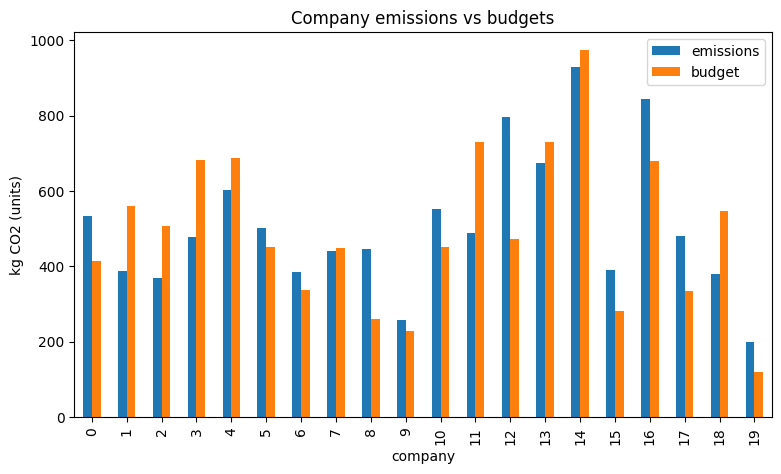

In [24]:
# Summary table
rows = []
for c, info in company_results.items():
    rows.append({
        'company': c,
        'customers': len(info['customers']),
        'vehicles': info['vehicles_assigned'],
        'distance': info['baseline_distance'],
        'emissions': info['baseline_emissions'],
        'budget': info['budget'],
        'bought': info['tokens_bought'],
        'sold': info['tokens_sold'],
        'payment': info['token_payment'],
        'revenue': info['token_revenue']
    })
df = pd.DataFrame(rows).set_index('company')
display(df)

# Emissions bar chart
df[['emissions','budget']].plot(kind='bar')
plt.ylabel('kg CO2 (units)')
plt.title('Company emissions vs budgets')
plt.show()
